    Import Required Libraries

In [20]:
import os
import cv2
import pafy
# import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
# from collections import deque
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import visualkeras

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


Set Numpy, Python and Tensorflow seeds to a constant to get consistent results on every execution

In [21]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

    1. Visualize the Dataset

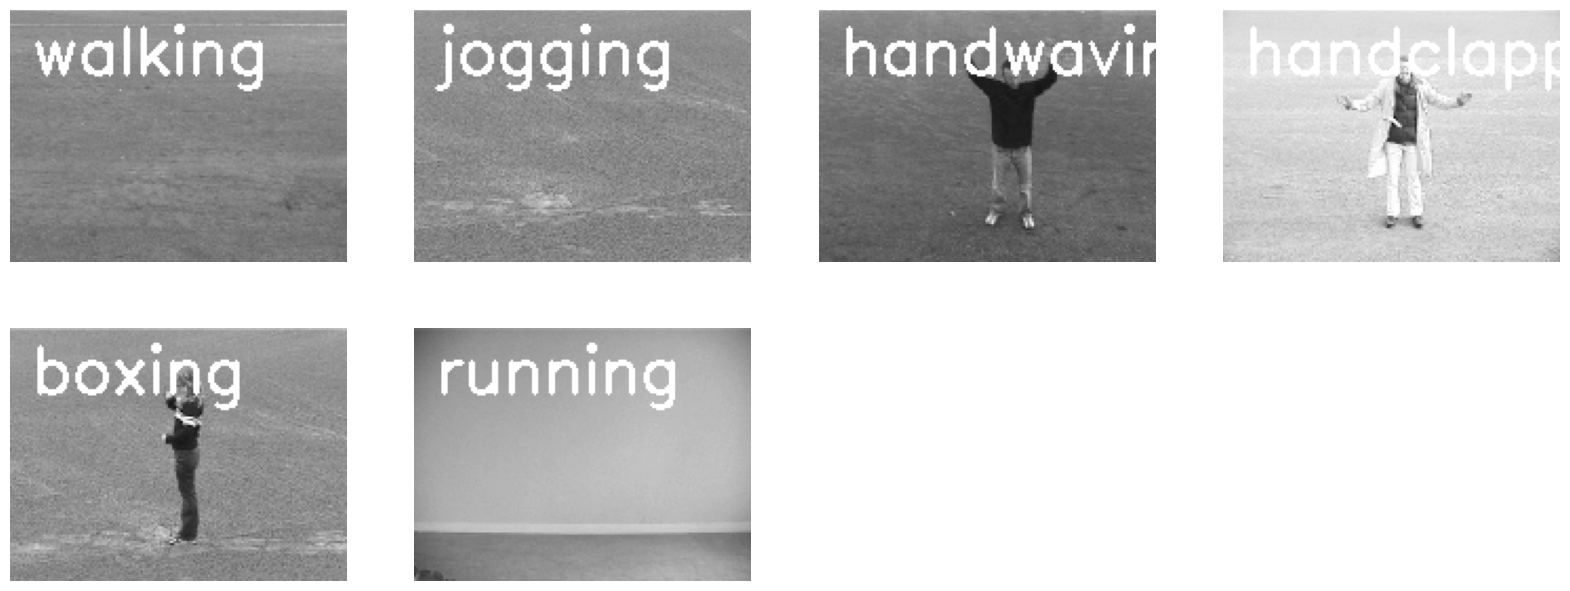

In [22]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('KTH')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'KTH/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'KTH/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

    2. Preprocess the Dataset

        2.1. Initialize Constants

In [23]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "KTH"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["boxing", "handwaving", "running", "walking"]

        2.2. Define Function to Extract Frames from a Video

In [24]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

        2.3. Define Function to Create Dataset

In [25]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [26]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: boxing


Extracting Data of Class: handwaving
Extracting Data of Class: running
Extracting Data of Class: walking


        2.4. Encode the Frames

In [27]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

        2.5. Split the Data Into Train and Test Sets

In [28]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

    3. Implement the ResNet50 Approach

        3.1. Construct the Model

In [29]:
def create_ResNet_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                   pooling='avg', classes=len(CLASSES_LIST),
                   weights='imagenet')
    for layer in pretrained_model.layers:
        layer.trainable=False
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(pretrained_model, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [30]:
# Construct the required LRCN model.
ResNet_model = create_ResNet_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 20, 2048)          23587712  
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 2048)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 32)                266368    
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 23854212 (91.00 MB)
Trainable params: 266500 (1.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Model Cre

        3.2. Check the Model Structure

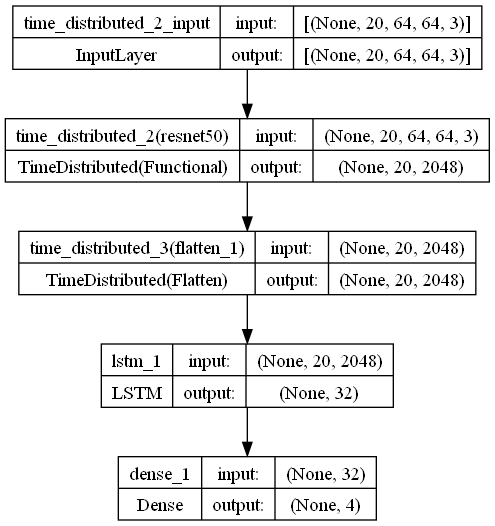

In [31]:
# Plot the structure of the contructed LRCN model.
plot_model(ResNet_model, to_file = 'ResNet_model_structure_plot.png', show_shapes = True, show_layer_names = True)

        3.3. Compile and Train the Model

In [32]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
ResNet_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
ResNet_model_training_history = ResNet_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
60/60 [==============================] - 58s 844ms/step - loss: 1.4191 - accuracy: 0.2845 - val_loss: 1.3771 - val_accuracy: 0.2167
Epoch 2/70
60/60 [==============================] - 42s 698ms/step - loss: 1.3613 - accuracy: 0.3431 - val_loss: 1.3093 - val_accuracy: 0.4167
Epoch 3/70
60/60 [==============================] - 42s 698ms/step - loss: 1.2749 - accuracy: 0.3849 - val_loss: 1.1548 - val_accuracy: 0.4167
Epoch 4/70
60/60 [==============================] - 40s 674ms/step - loss: 1.1033 - accuracy: 0.4979 - val_loss: 0.9359 - val_accuracy: 0.4500
Epoch 5/70
60/60 [==============================] - 47s 784ms/step - loss: 1.0511 - accuracy: 0.4686 - val_loss: 1.0207 - val_accuracy: 0.4667
Epoch 6/70
60/60 [==============================] - 48s 800ms/step - loss: 0.9536 - accuracy: 0.4937 - val_loss: 0.8566 - val_accuracy: 0.5000
Epoch 7/70
60/60 [==============================] - 41s 691ms/step - loss: 0.9119 - accuracy: 0.5356 - val_loss: 1.0996 - val_accuracy: 0.3833

        3.4. Evaluate the Trained Model

In [ ]:
# Evaluate the trained model.
model_evaluation_history = ResNet_model.evaluate(features_test, labels_test)

4/4 [==============================] - 14s 3s/step - loss: 0.6922 - accuracy: 0.6200


In [ ]:
# Get model predictions for the test dataset
predictions = ResNet_model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot-encoded predictions to class indices

# Calculate the confusion matrix
confusion_mat = confusion_matrix(np.argmax(labels_test, axis=1), predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

4/4 [==============================] - 13s 2s/step
Confusion Matrix:
[[13 16  0  0]
 [ 3 20  0  0]
 [ 0  0 11 17]
 [ 0  0  2 18]]


        3.5. Save the Model

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'ResNet_model_Date_Time_{current_date_time_string}_Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
ResNet_model.save(model_file_name)

        3.6. Plot Model Evaluation Curves

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

            3.6.1. Loss Curves

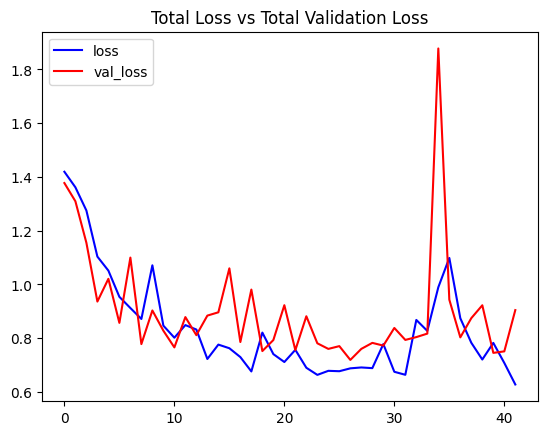

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(ResNet_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

            3.6.2. Accuracy Curves

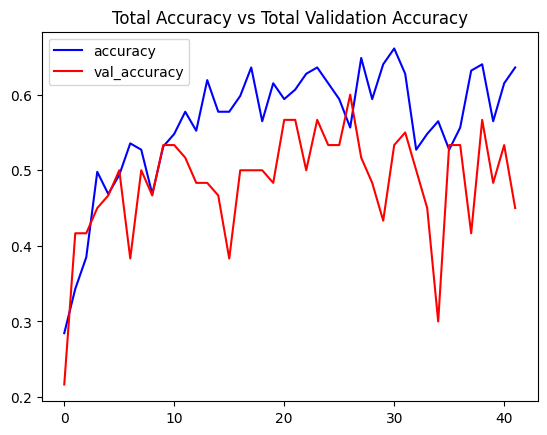

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(ResNet_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')